# Spatial Data Science 5: Discovering Clusters

"Clusters" are a common concern for spatial analysis. We saw one way to detect spatial clusters/outliers in the third notebook, but here we'll show a few other strategies that can be used on point and lattice data. 

In [2]:
import numpy as np
import libpysal.weights as lp
import geopandas as gpd
import pandas as pd
import shapely.geometry as shp
import matplotlib.pyplot as plt
import sklearn.metrics as skm
import seaborn as sns
%matplotlib inline

## Point Clustering
First, we'll work with the point data to find regions where airbnbs colocate. 

In [3]:
listings = pd.read_csv('./data/berlin-listings.csv.gz')
listings['geometry'] = listings[['longitude','latitude']].apply(shp.Point, axis=1)
listings = gpd.GeoDataFrame(listings)
listings.crs = {'init':'epsg:4269'}
listings = listings.to_crs(epsg=3857)

/usr/local/lib/python3.7/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:>

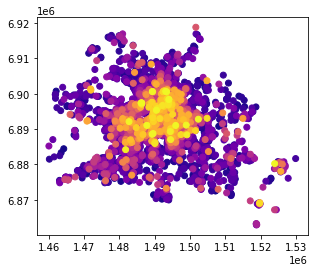

In [4]:
listings.sort_values('price').plot('price', cmap='plasma')

Now, we'll need the `scikit-learn` cluster module, which has quite a few tools that can be used to identify these clusters:

Since we're interested in the locations and `sklearn` isn't conversant in geodataframes, we'll need to get the point array from the geodataframe:

In [53]:
listings[["geometry"]].head()

,geometry
0,POINT (1491246.091 6906289.706)
1,POINT (1491523.302 6905027.621)
2,POINT (1491598.865 6907372.953)
3,POINT (1491189.631 6906107.655)
4,POINT (1490975.657 6906370.805)


In [51]:
import sklearn.cluster as skc
coordinates = listings['geometry'].apply(lambda p: np.hstack(p.xy)).values
coordinates = np.vstack(coordinates)
coordinates

array([[1491246.09061424, 6906289.70588367],
       [1491523.30240249, 6905027.62143263],
       [1491598.86544802, 6907372.95286508],
       ...,
       [1483626.59167149, 6909789.47565835],
       [1484643.05708275, 6911169.65547772],
       [1524454.54949633, 6867174.51240984]])

Like other scikit estimators, they are split into an initialization/configuration call and a fit call.

Here, we'll use a local density-based scan clusterer, called DBSCAN. It works by fitting clusters of nearby points using the `eps` distance, which is the furthest distance at which points are considered to be in each other's clusters, kind of like the distance-band weight we talked about in first notebook. 

In [7]:
clusterer = skc.DBSCAN(eps=1000).fit(coordinates)

Now, `clusterer` contains all of the observations found to be components of clusters:

In [8]:
clusterer.components_

array([[1491246.09061424, 6906289.70588367],
       [1491523.30240249, 6905027.62143263],
       [1491598.86544802, 6907372.95286508],
       ...,
       [1484839.95240176, 6903009.17762691],
       [1486389.18508418, 6903758.10772346],
       [1486722.30038881, 6904230.45907474]])

It also contains the indices of the observations found to be "cores" of the clusters detected:

In [9]:
clusterer.core_sample_indices_

array([    0,     1,     2, ..., 20047, 20048, 20049])

As well as their labels, which are the quantity of interest here, the main thing we wanted to detect:

In [10]:
clusterer.labels_

array([ 0,  0,  0, ...,  6, -1, -1])

In addition, the number of discovered clusters is contained in the `p` attribute. 

In [11]:
nclusters = clusterer.p

To map the clusters, we need to assign them back to the dataframe and plot them:

<AxesSubplot:>

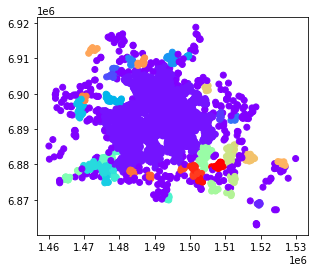

In [12]:
listings.assign(labels=clusterer.labels_).plot('labels', k=nclusters, cmap='rainbow')

# Areal clusters

Areal clusters are usually slightly harder to identify, since we might mean *two* things when we say "areal cluster." 

The first sense refers to *clusters in data* that can be visualized, kind of like what we were talking about in second notebook. 

The second sense refers to *contiguous areas of similarity* in data, which require slightly different approaches to discover. 

We'll tackle the first sense first at the neighbourhood level:

In [13]:
neighborhood = gpd.read_file('./data/berlin-neighbourhoods.geojson').to_crs(epsg=3857)
median_prices = listings.groupby('neighbourhood_cleansed').price.median().to_frame('median_price')
neighborhood = neighborhood.merge(median_prices, left_on='neighbourhood', right_index=True)
neighborhood = gpd.GeoDataFrame(neighborhood)

<AxesSubplot:>

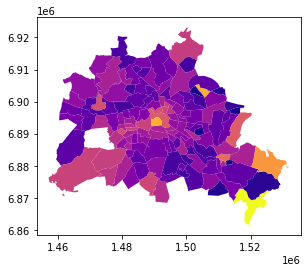

In [14]:
neighborhood.plot('median_price', cmap='plasma')

One of the more helpful & flexible clusterers in `scikit-learn` is the ward agglomerative clusterer, which aims to build good clusters from pairwise aggregations of data

<AxesSubplot:>

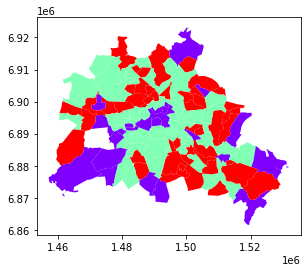

In [54]:
neighborhood_priceclusters = skc.AgglomerativeClustering(n_clusters=3).fit(neighborhood[['median_price']])
neighborhood.assign(labels=neighborhood_priceclusters.labels_).plot('labels', cmap='rainbow')

In [57]:
neighborhood.assign(labels=neighborhood_priceclusters.labels_).head()

,neighbourhood,neighbourhood_group,geometry,median_price,labels
0,Blankenfelde/Niederschönhausen,Pankow,"MULTIPOLYGON (((1493006.880 6912074.798, 14929...",37.5,2
1,Helmholtzplatz,Pankow,"MULTIPOLYGON (((1493245.549 6900059.696, 14932...",58.0,0
2,Wiesbadener Straße,Charlottenburg-Wilm.,"MULTIPOLYGON (((1481381.452 6885170.698, 14813...",50.0,1
3,Schmöckwitz/Karolinenhof/Rauchfangswerder,Treptow - Köpenick,"MULTIPOLYGON (((1526159.829 6872101.044, 15261...",99.0,0
4,Müggelheim,Treptow - Köpenick,"MULTIPOLYGON (((1529265.086 6874326.842, 15292...",25.0,2


Note that these are all broken up around the map; while we've found three clusters with similar prices, there is no guarantee that these solutions will be connected spatially, and indeed we often find that this is the case. 

As to measure the quality of clusters in the map, we can use the `silhouette score`, which is a standardized distance between each observation's data and the "decision boundary," or the nearest cluster that we *didn't* put the observation into. 

In [17]:
silhouettes = skm.silhouette_samples(neighborhood[['median_price']], neighborhood_priceclusters.labels_)

<AxesSubplot:>

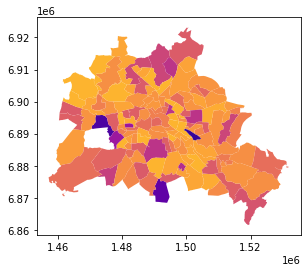

In [18]:
neighborhood.assign(strength = silhouettes).plot('strength', cmap='plasma', vmin=-.5,vmax=1)

The `mapclassify` package has some algorithms to do clustering as well, such as the Fisher Jenks optimal classification method, which finds solutions to k-means-style problems fast & efficiently:

<AxesSubplot:>

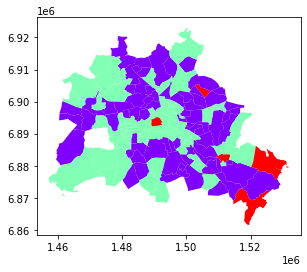

In [58]:
from mapclassify.classifiers import FisherJenks
fisher_jenks = FisherJenks(neighborhood.median_price, k=3).yb
neighborhood.assign(labels=fisher_jenks).plot('labels', cmap='rainbow')

Sometimes, this outperforms the Agglomerative solutions:

In [29]:
silhouettes_fj = skm.silhouette_samples(neighborhood[['median_price']], fisher_jenks)

<AxesSubplot:>

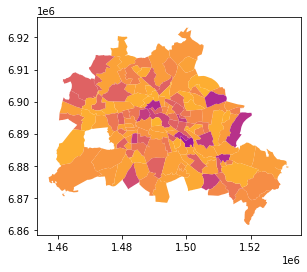

In [30]:
neighborhood.assign(strength = silhouettes_fj).plot('strength', cmap='plasma', vmin=-.5,vmax=1)

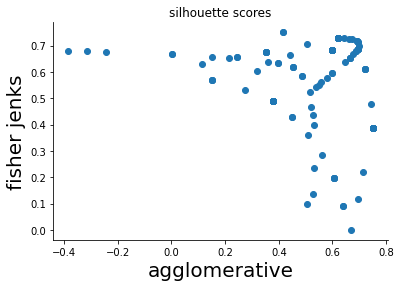

In [31]:
plt.scatter(silhouettes, silhouettes_fj)
plt.xlabel("agglomerative", fontsize=20)
plt.title("silhouette scores")
plt.ylabel("fisher jenks", fontsize=20)
sns.despine()

In [32]:
skm.silhouette_score(neighborhood[['median_price']], fisher_jenks)

0.5605668091719826

In [33]:
skm.silhouette_score(neighborhood[['median_price']], neighborhood_priceclusters.labels_)

0.5335887580400264

Another implementation in `scikit` is in their `KMeans` classifier. 

### Contiguous clusters

Finding contiguous clusters is much harder computationally.

But, we can adapt the agglomerative clusterer in scikit-learn to find contiguous clusters in our data using our connectivity graphs from `sds1-geography_as_feature.ipynb`:

In [36]:
import libpysal.weights as lp

In [37]:
rook_graph = lp.Rook.from_dataframe(neighborhood)

the Agglomerative clustering configuration takes an argument, `connectivity`, which is used to constrain how individual observations are grouped together as the solution is being built. By passing the sparse matrix encoding our adjacency graph to this option, only adjcent observations will be grouped as the solution is built. This rule, only ever grouping neighboring observations, is sufficient to ensure that the resulting clusters are connected. 

In [38]:
neighborhood_priceclusters_sp = skc.AgglomerativeClustering(n_clusters=3,
                                                         connectivity=rook_graph.sparse).fit(neighborhood[['median_price']])

<AxesSubplot:>

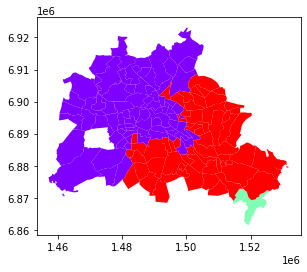

In [39]:
neighborhood.assign(labels=neighborhood_priceclusters_sp.labels_).plot('labels', cmap='rainbow')

see?

### Probabilistic clustering

Sometimes, we'd rather treat clustering assignments as "predictions" in a probabilistic framework. Often, this is done either through latent dirichlet allocation or, more simply, through Gaussian mixture models. 

Scikit's gaussian mixture methods are also fast and simple to use, so Ill show them below:

In [40]:
import sklearn.mixture as skmix

Since Gaussian mixutre models are probabilistic, they are sensitive to the random seeds with which we populate the problem. Therefore, I'll pass today's date as a number to make sure the solutions are the same each time (but you don't have to use this seed!)

In [41]:
gmm = skmix.GaussianMixture(n_components=3, random_state=7052018).fit(neighborhood[['median_price']])

The Gaussian mixture models have a slightly different interface; to get the labels for the assignments on your trained classifier, you have to use the `predict` method:

In [42]:
predicted = gmm.predict(neighborhood[['median_price']])

Further, if you want the probabilities around the assignments, you can use the `predict_proba` method:

In [43]:
strengths = gmm.predict_proba(neighborhood[['median_price']])

This gives the full matrix of probabilities (over all clusters).

In [44]:
strengths[0:5]

array([[8.12234237e-01, 3.36664575e-04, 1.87429098e-01],
       [2.27849052e-02, 3.43470611e-02, 9.42868034e-01],
       [1.87906330e-01, 5.42612080e-03, 8.06667549e-01],
       [2.66802059e-16, 9.99999846e-01, 1.53895689e-07],
       [9.74290541e-01, 6.14636516e-05, 2.56479954e-02]])

So, just to focus on the probability of assignment to the "most likely" cluster, we can take the maximum probability over the rows of the `strengths` matrix:

In [45]:
strength = strengths.max(axis=1)

In [46]:
strength[0:5]

array([0.81223424, 0.94286803, 0.80666755, 0.99999985, 0.97429054])

now, we can make another map showing the assignments and the probabilities with which those assignments are made, kind of like our silhouette scores above:

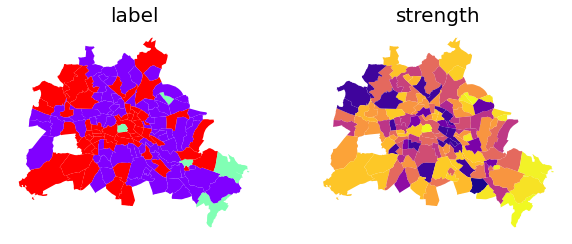

In [47]:
f,ax = plt.subplots(1,2,figsize=(10,4))
neighborhood.assign(labels=predicted).plot('labels',ax=ax[0],cmap='rainbow')
neighborhood.assign(strength=strength).plot('strength', cmap='plasma', ax=ax[1], vmin=.5, vmax=1)
for i in range(2):
    ax[i].axis('off')
    ax[i].set_title(["label","strength"][i], fontsize=20)

but, these assignment probabilities are *not* the same as the silhouette scores, and often have quite a different structure from the silhouette scores. 

In [48]:
silhouettes_gmm = skm.silhouette_samples(neighborhood[['median_price']], predicted)

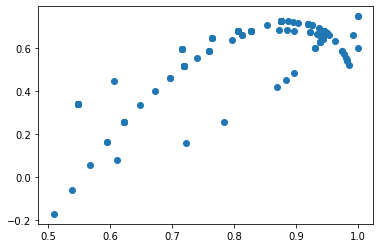

In [49]:
plt.scatter(strength, silhouettes_gmm)